In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../')

from sdebridge import diffusion_bridge as db
from sdebridge import sdes
from sdebridge.utils import score_fn
from sdebridge.data_processing import sample_ellipse

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [3]:
T=1.
Nt=100
dim=2
N = 11
alpha=0.1
sigma=1.0
Ngrid = 5
grid_range = (-1, 2.)

forward_init = sample_ellipse(N)
forward_init = jnp.expand_dims(forward_init, axis=0)
kunita_sde = sdes.gaussian_independent_kernel_sde(T, Nt, dim, N, alpha, sigma, Ngrid, grid_range)

In [4]:
key = jax.random.PRNGKey(2)
forward_trajs= sdes.simulate_traj(kunita_sde, forward_init, 2, key)

diffusion_.shape=(1, 11, 25)
eps.shape=(1, 25, 2)


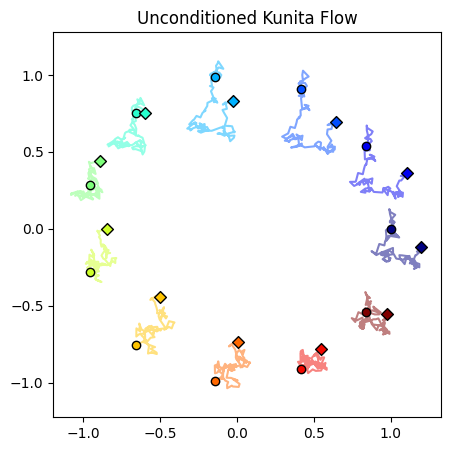

In [5]:
from sdebridge.plotting import plot_single_trajectory

traj = forward_trajs[0].reshape(-1, N*dim)
plot_single_trajectory(traj, "Unconditioned Kunita Flow")

In [6]:
from sdebridge.networks.score_unet import ScoreUNet

neural_net = ScoreUNet

network = {
    "output_dim": kunita_sde.dim*kunita_sde.n_bases,
    "time_embedding_dim": 32,
    "init_embedding_dim": 32,
    "act_fn": "silu",
    "encoder_layer_dims": [64, 32, 16, 8],
    "decoder_layer_dims": [8, 16, 32, 64],
    "batchnorm": True,
}
    
training= {
    "batch_size": 100,
    "load_size": 5000,
    "num_epochs": 20,
    "learning_rate": 5e-3,
    "warmup_steps": 0,
}

target = sample_ellipse(N)
target = jnp.expand_dims(target, axis=0)
train_key = jax.random.split(key, 2)[0]
score_state_p = db.learn_p_score(kunita_sde, target, train_key, **training, net=neural_net, network_params=network)

Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

scores.shape=(9900, 1, 11, 2), grads.shape=(9900, 1, 11, 2), covs.shape=(9900, 1, 11, 11)


Training: 100%|██████████| 20/20 [01:53<00:00,  5.67s/epoch, Epoch=20, loss=86810.2266]


In [9]:
initial_val = sample_ellipse(N, scale=0.5)
initial_val = jnp.expand_dims(initial_val, axis=0)
score_p = score_fn(score_state_p)
reverse_sde = sdes.reverse(kunita_sde, score_p)
backward_trajs = sdes.simulate_traj(reverse_sde, initial_val, 2, train_key)

diffusion_.shape=(1, 11, 25)
eps.shape=(1, 25, 2)


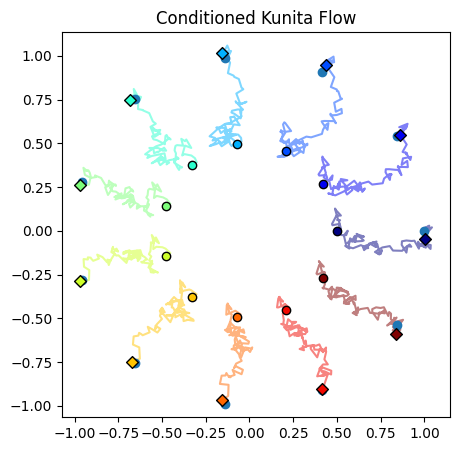

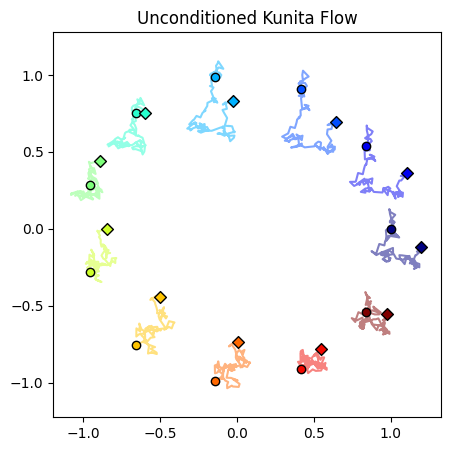

In [10]:
plt_init = target.reshape((-1, 2))

traj = backward_trajs[0].reshape(-1, N*dim)
plot_single_trajectory(traj, "Conditioned Kunita Flow")
plt_target = target.reshape((N, 2))
plt.scatter(plt_init[:, 0], plt_init[:, 1])
traj = forward_trajs[0].reshape(-1, N*dim)
plot_single_trajectory(traj, "Unconditioned Kunita Flow")